In [2]:
import pandas as pd
pd.set_option('display.max_columns',None)
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
cancer_df = pd.read_csv('../data/us_cancer_center_720.csv').iloc[:,1:]
cancer_df.rename(columns = {'Name (Specialty)':'NAME',
                            'AHA ID':'AHA_ID',
                            'Specialty Score':'SCORE',
                            'Specialty Ranking':'RANKING'}, inplace = True)
print(cancer_df.shape)
cancer_df.head()

(720, 8)


,NAME,AHA_ID,ZIP,STATE,SCORE,RANKING,LATITUDE,LONGITUDE
0,University of Texas MD Anderson Cancer Center,6741945,77030,TX,100.0/100,1.0,29.707670,-95.397844
1,Mayo Clinic,6610451,53821,WI,79.9/100,3.0,43.051688,-91.132867
2,UCLA Medical Center,6931755,90095,CA,73.2/100,5.0,34.065563,-118.445498
3,Cleveland Clinic,6410670,44333,OH,71.9/100,6.0,41.131162,-81.610786
4,Cedars-Sinai Medical Center,6930444,90048,CA,67.7/100,11.0,34.075160,-118.381094


# Find any missing value

In [9]:
cancer_df.isna().sum()

NAME           0
AHA_ID         0
ZIP            0
STATE          0
SCORE          0
RANKING      692
LATITUDE       0
LONGITUDE      0
dtype: int64

[Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '4'),
 Text(0, 0, '4'),
 Text(0, 0, '4'),
 Text(0, 0, '4'),
 Text(0, 0, '4'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '5'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '8'),
 Text(0, 0, '10'),
 Text(0, 0, '10'),
 Text(0, 0, '10'),
 Text(0, 0, '11'),
 Text(0, 0, '12'),
 Text(0, 0, '12'),
 Text(0, 0, '13'),
 Text(0, 0, '13'),
 Text(0, 0, '13'),
 Text(0, 0, '13'),
 Text(0, 0, '16'),
 Text(0, 0, '16'),
 Text(0, 0, '17'),
 Text(0, 0, '19'),
 Text(0, 0, '19'),
 Text(0, 0, '19'),
 Text(0, 0, '20'),
 Text(0, 0, '20'),
 Text(0, 0, '22'),
 Text(0, 0, '28'),
 Text(0, 0, '29'),
 Text(0, 0, '30'),
 Text(0, 0, '43'),
 Text(0, 0, '45'),
 Text(0, 0, '48'),
 Text(0, 0, '48'),
 Text(0, 0, '68')]

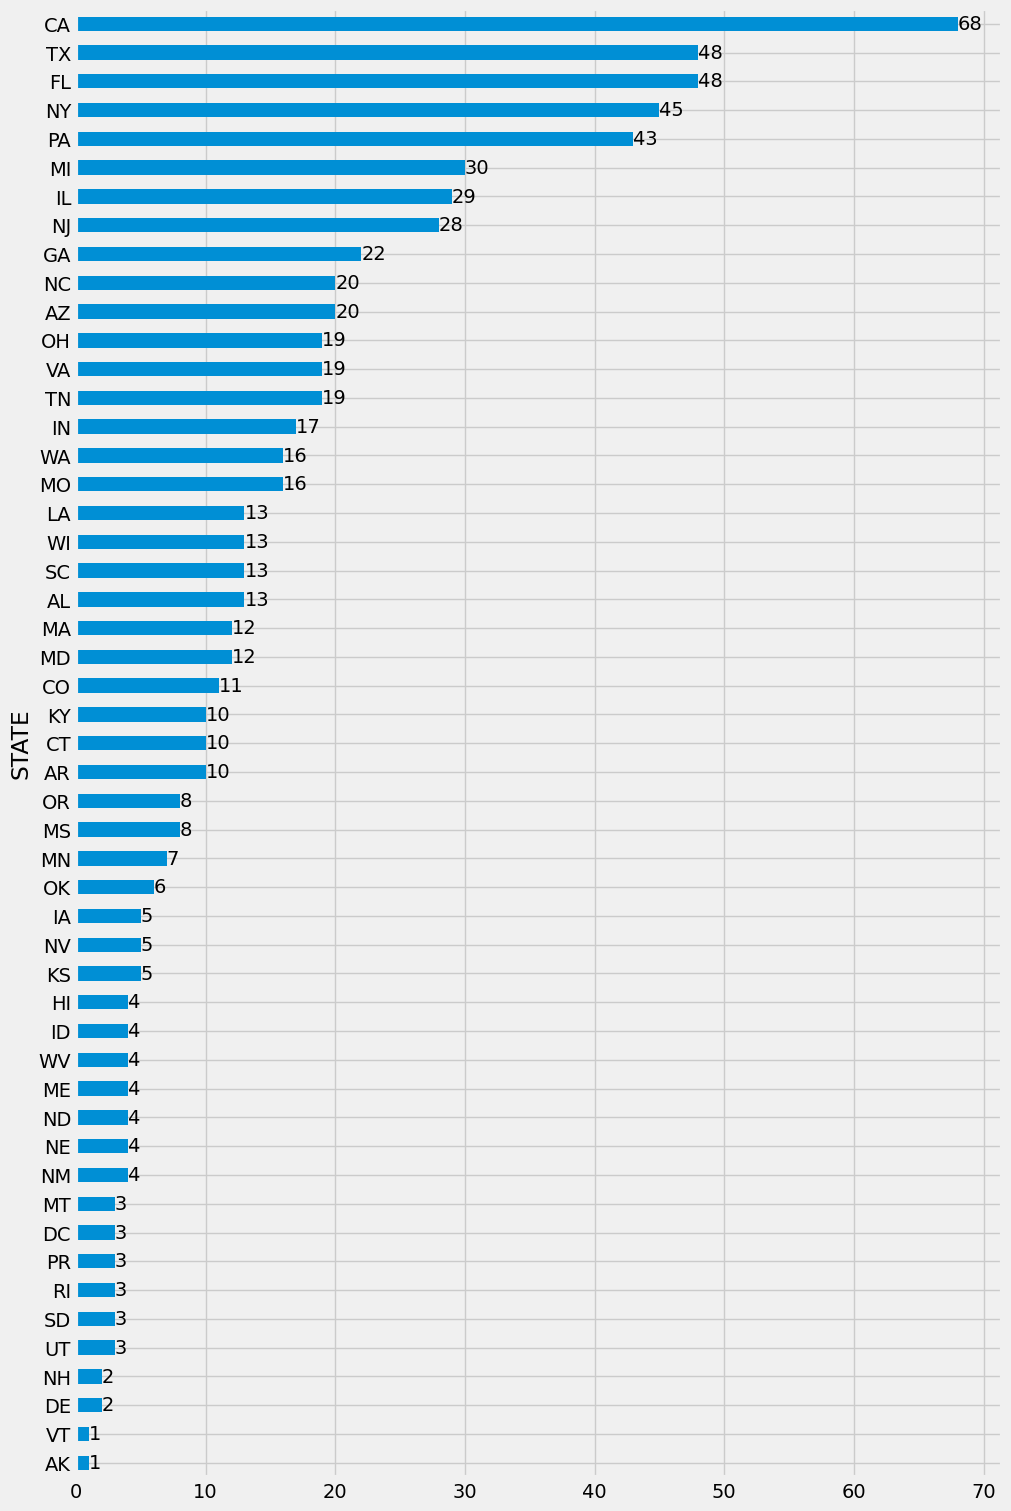

In [15]:
plt.figure(figsize=(10, 15),constrained_layout=True)
plt.style.use('fivethirtyeight')
ax = cancer_df.groupby(['STATE'])['NAME'].size().sort_values().plot.barh()
ax.bar_label(ax.containers[0])